In [1]:
%pylab inline
from tvb.simulator.lab import *

Populating the interactive namespace from numpy and matplotlib
   INFO  log level set to INFO


c:\users\gabriel.florea\desktop\mywork\tvb_2\tvb-library\tvb\datatypes\surfaces.py:66: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.wilson_cowan.WilsonCowan.state_variable_range = Final(field_type=<class 'dict'>, default={'E': array([0., 1.]), 'I': array([0., 1.])}, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.stefanescu_jirsa.ReducedSetFitzHughNagumo.state_variable_range = Final(field_type=<class 'dict'>, default={'xi': array([-4.,  4.]), 'eta': array([-3.,  3.]), 'alpha': array([-4.,  4.]), 'beta': array([-3.,  3.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindmarshRose.a = NArray(label=':math:`a`', dtype=float64, default=array([1.]), dim_names=(), ndim=None, required=True)
WARNING  default contains values out of the declared domain. Ex 3.0 
   attribute  tvb.simulator.models.st

WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.wong_wang_exc_io_inh_i.ReducedWongWangExcIOInhI.state_variable_range = Final(field_type=<class 'dict'>, default={'S_e': array([0., 1.]), 'S_i': array([0., 1.])}, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.linear.Linear.state_variable_range = Final(field_type=<class 'dict'>, default={'x': array([-1,  1])}, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.hopfield.Hopfield.state_variable_range = Final(field_type=<class 'dict'>, default={'x': array([-1.,  2.]), 'theta': array([0., 1.])}, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor.state_var

Having multiple stimuli with different time courses for different nodes currently requires an extra class, see usage below

In [2]:
class MultiStimuliRegion(patterns.StimuliRegion):
    def __init__(self, *stimuli):
        self.stimuli = stimuli
    def configure_space(self, *args, **kwds):
        [stim.configure_space(*args, **kwds) for stim in self.stimuli]
    def configure_time(self, *args, **kwds):
        [stim.configure_time(*args, **kwds) for stim in self.stimuli]
    def __call__(self, *args, **kwds):
        return np.array([stim(*args, **kwds) for stim in self.stimuli]).sum(axis=0)

Now we can make several pulse trains with different temporal configurations and node weights, and combine them with above class.

WARNING  File 'hemispheres' not found in ZIP.


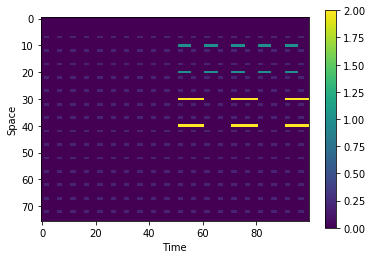

In [3]:
conn = connectivity.Connectivity.from_file()
nnode = conn.weights.shape[0]

def make_train(node_idx, node_weights, **params):
    weighting = np.zeros(nnode)
    weighting[node_idx] = node_weights
    eqn_t = equations.PulseTrain()
    eqn_t.parameters.update(params)
    stimulus = patterns.StimuliRegion(
        temporal=eqn_t,
        connectivity=conn,
        weight=weighting)
    return stimulus

train1 = make_train([10, 20], 1.0, onset=1.5e3, T=100.0, tau=50.0)
train2 = make_train([30, 40], 2.0, onset=1.5e3, T=200.0, tau=100.0)
train3 = make_train(r_[7:74:5], 0.2, onset=5e2, T=50.0, tau=20.0)
stimulus = MultiStimuliRegion(train1, train2, train3)
stimulus.configure_space()
time = r_[1e3:2e3:10.0]
stimulus.configure_time(time)
pattern = stimulus()
imshow(pattern, interpolation='none')
xlabel('Time')
ylabel('Space')
colorbar()

Here we just visualize the output of `stimulus`, but it could also be passed to a simulator object for simulation.